# Hàm Chung

In [31]:
import matplotlib.pyplot as plt

def read_log(files):
    result = dict()
    for f in files:
        trains = []
        vals = []
        with open(f, 'r') as file:
            for line in file:
                data = line.strip().split(' ')
                trains.append(float(data[5].replace(',', '')))
                vals.append(float(data[8].replace(',', '')))
        name = f.split('/')[-1].split('.')[0]
        result[name] = [trains, vals]
    return result

def read_log_raw(file):
    result = dict()
    start = 0
    with open(file, 'r', encoding='utf-8') as file:
        data = file.read().split('\n')
        while True:
            name = data[start].split('-')[2]
            logs = data[start+1:start+31]
            trains = []
            vals = []
            for log in logs:
                log = log.strip().split(' ')
                trains.append(float(log[5].replace(',', '')))
                vals.append(float(log[8].replace(',', '')))
            result[name] = [trains, vals]
            start += 32
            if start >= len(data):
                return result

def print_plot(files, file_raw = False, max_col=3, ticks = {}):
    if file_raw:
        logs = read_log_raw(files)
    else:
        logs = read_log(files)

    num_files = len(logs)
    num_rows = (num_files + max_col - 1) // max_col  # Tính số hàng cần thiết

    fig, axs = plt.subplots(num_rows, max_col, figsize=(5 * max_col, 4 * num_rows))
    axs = axs.flatten()  # Biến mảng 2D thành 1D để dễ index
    for idx, key in enumerate(logs.keys()):
        trains, vals = logs[key]
        if idx in ticks:
            axs[idx].set_facecolor(ticks.get(idx, '#e6f7ff'))
        axs[idx].plot(trains, label='Train')
        axs[idx].plot(vals, label='Val')
        axs[idx].set_title(key)
        axs[idx].set_xlabel('Epoch')
        axs[idx].set_ylabel('Loss')
        axs[idx].legend()
        axs[idx].grid(True)
        axs[idx].set_ylim(0, 1)

    # Tắt các subplot dư nếu có
    for i in range(num_files, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

# TRƯỜNG HỢP CÓ TẤT CẢ HƯỚNG ĐI

## Huấn Luyện Trước 50 Để Khảo Sát

## 1 kênh màu

In [12]:
path = './logs/all_type_ways'
files = [
    f'{path}/resnet18_50epochs.txt',
    f'{path}/vgg16_50epochs.txt',
    f'{path}/custom_50epochs.txt'
]

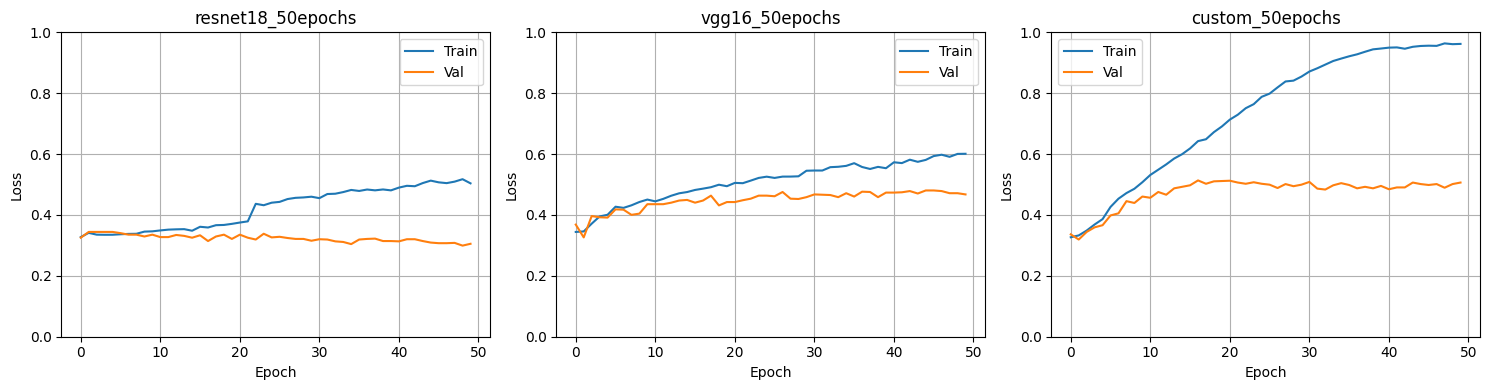

In [13]:
print_plot(files)

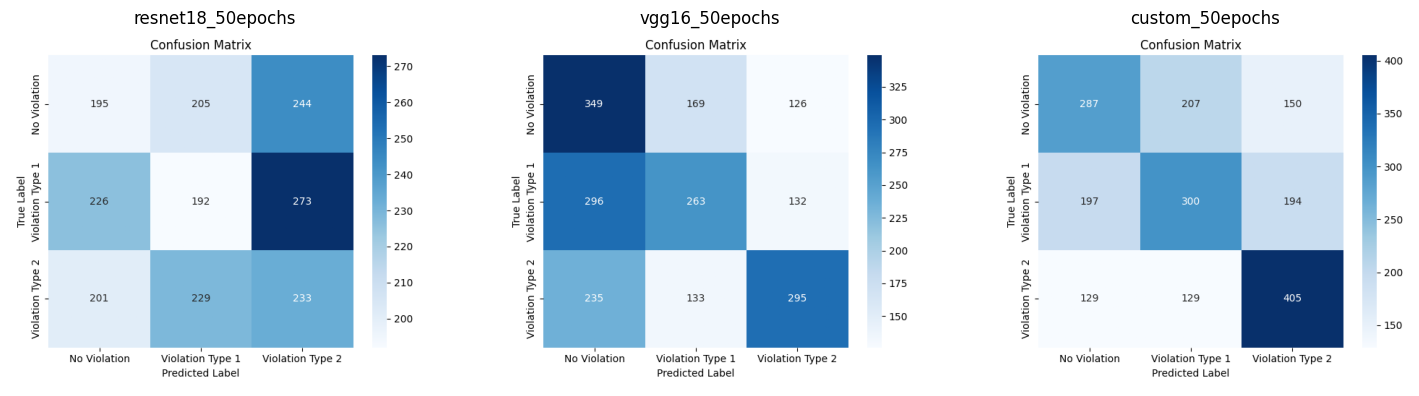

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

path = './logs/all_type_ways'
imgs = [
    f'{path}/resnet18_50epochs.png',
    f'{path}/vgg16_50epochs.png',
    f'{path}/custom_50epochs.png'
]

# Số cột trong lưới ảnh
max_col = 3
num_files = len(imgs)
num_rows = (num_files + max_col - 1) // max_col

fig, axs = plt.subplots(num_rows, max_col, figsize=(5 * max_col, 4 * num_rows))
axs = axs.flatten()

for idx, img_path in enumerate(imgs):
    img = mpimg.imread(img_path)
    axs[idx].imshow(img)
    axs[idx].set_title(os.path.basename(img_path).split('.')[0])
    axs[idx].axis('off')  # Ẩn trục tọa độ

# Ẩn các subplot dư nếu có
for i in range(num_files, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

## 3 kênh màu

## Chạy Thực Nghiệm Các Trường Hợp Của Mô Hình Custom

### Lần 1

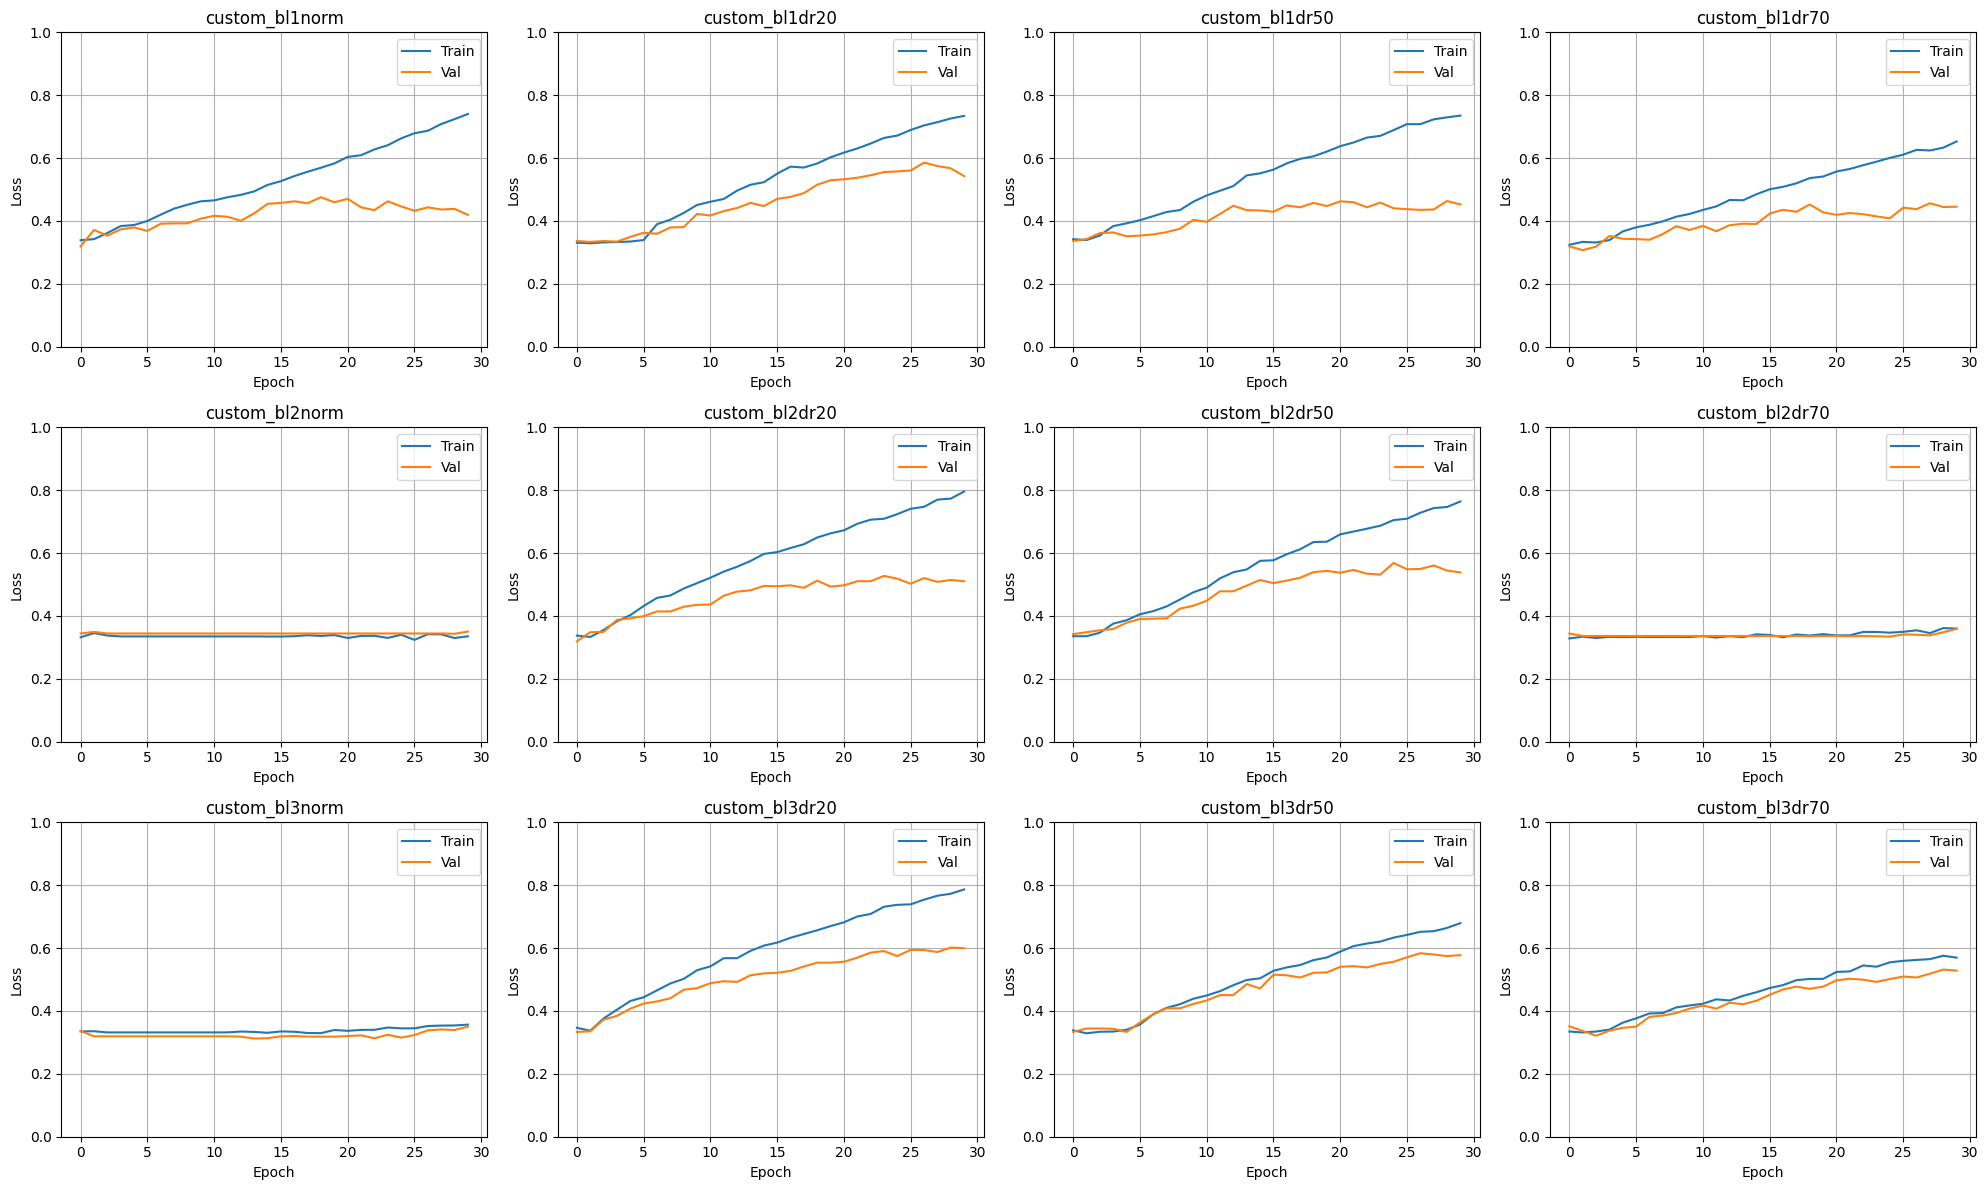

In [33]:
path = './logs/all_type_ways/log_raw_update_custom.txt'
print_plot(path, file_raw=True, max_col=4)

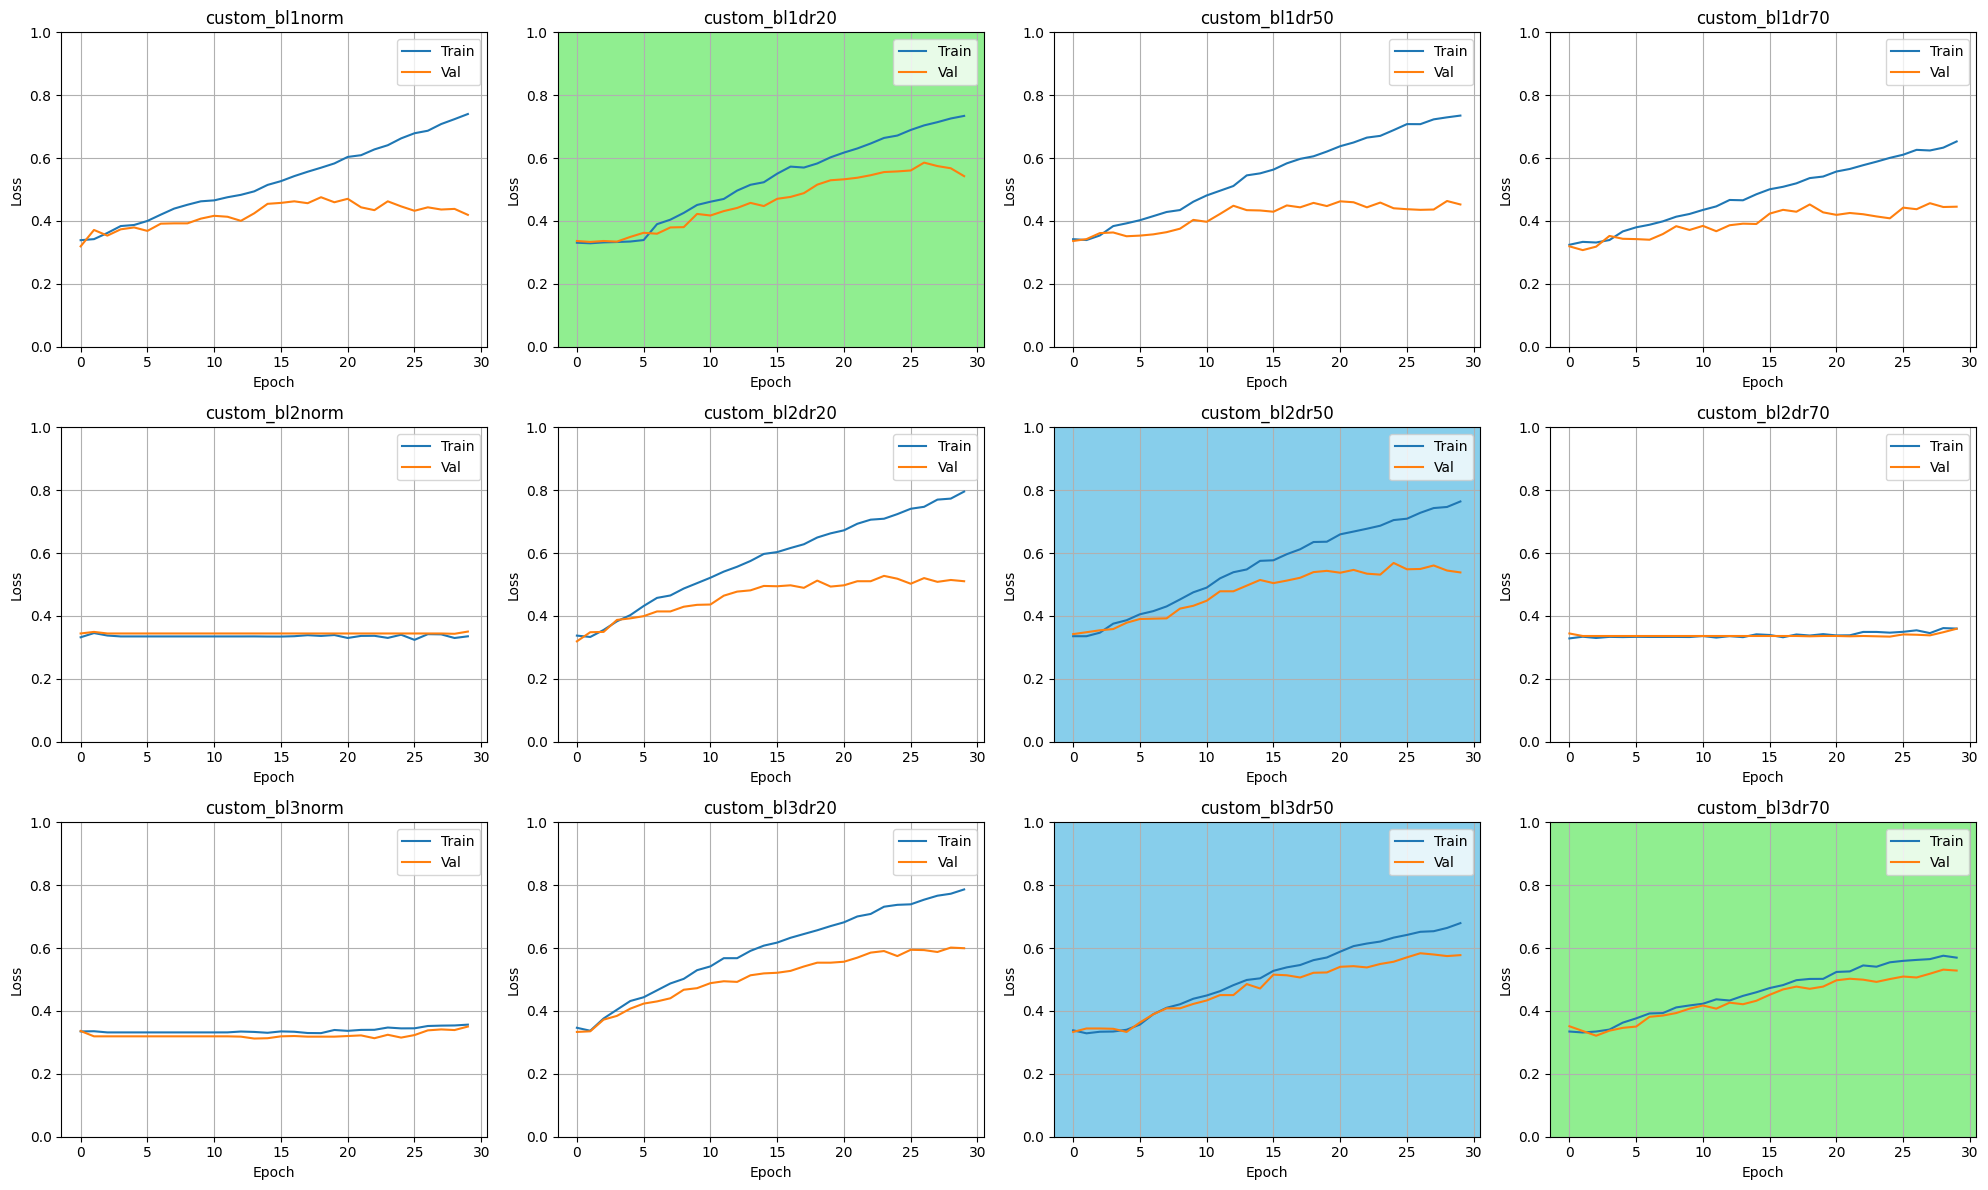

In [15]:
files = list([f'{path}/{f}.txt' for f in data_file.keys()])
print_plot(files, max_col=4 , ticks={1:'#90EE90', 6:'#87CEEB', 10:'#87CEEB', 11:'#90EE90'})

### Lần 2

In [14]:
data_file = {}
start = 0
path = './logs/all_type_ways'
with open(f'{path}/log_raw_update_custom_v2.txt', 'r', encoding='utf-8') as file:
    data = file.read().split('\n')
    while True:
        name = data[start].split('-')[2]
        logs = data[start+1:start+31]
        data_file[name] = logs
        start += 52
        if start >= len(data):
            break

for key, val in data_file.items():
    with open(f'{path}/{key}.txt', 'w', encoding='utf-8') as file:
        for line in val[:-1]:
            file.write(line+'\n')
        file.write(val[-1])

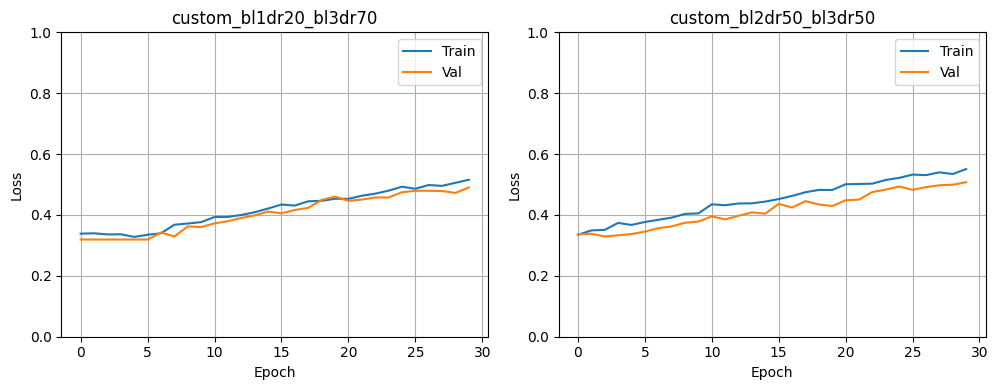

In [ ]:
# Lần 2
files = list([f'{path}/{f}.txt' for f in data_file.keys()])
print_plot(files, max_col=4)

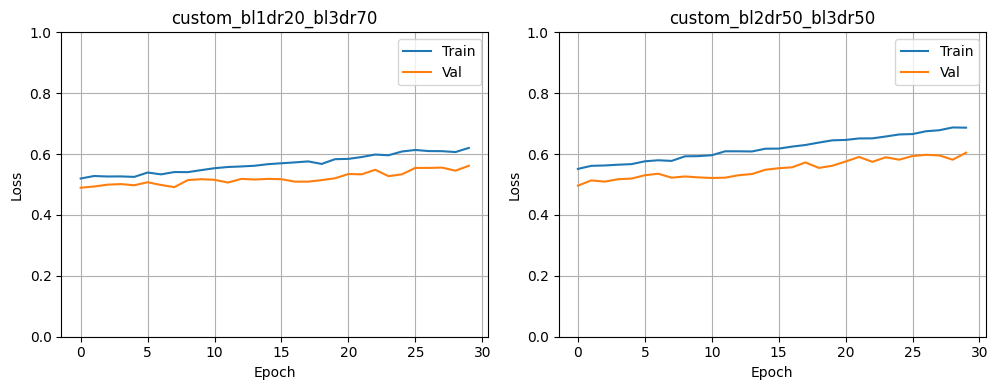

In [ ]:
# Lần 3
files = list([f'{path}/{f}.txt' for f in data_file.keys()])
print_plot(files, max_col=4)

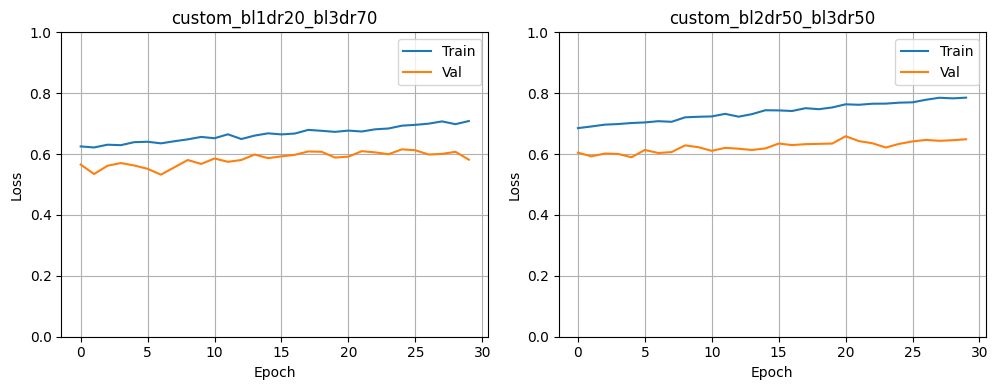

In [15]:
# Lần 4
files = list([f'{path}/{f}.txt' for f in data_file.keys()])
print_plot(files, max_col=4)